<a href="https://colab.research.google.com/github/hikaru122700/kaggle-pub/blob/GCI-titanic/16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic
![](https://i.imgur.com/rRFchA8.png)

## 目次
0. ライブラリ・データ読み込み
1. データの概観・分析・前処理
2. ベースラインモデルの構築
3. 特徴量エンジニアリング
4. 様々なモデルの構築・調整
5. モデルのアンサンブリング
6. 予測の出力・提出

　機械学習を用いたデータ分析では多くの場合、上の目次に示すような工程で問題に取り組みます。ただしこの順番に沿って一方向的に進んでいくのではなく、前後の工程を行ったり来たりしながら作業は進んでいきます。このような工程に関しては、Mark Peng氏による"General Tips for participating Kaggle Competitions"という講演資料で示されたフローチャート（下図）がわかりやすいです。またKaggleそのものについての解説は、Sergey Yurgenson氏による"Kaggle and Data Science"がわかりやすいでしょう。

"General Tips for participating Kaggle Competitions" : https://www.slideshare.net/markpeng/general-tips-for-participating-kaggle-competitions

"Kaggle and Data Science" : https://www.slideshare.net/hijiki_s/kaggle-and-data-science

![](https://image.slidesharecdn.com/kagglesharingmarkpeng20151216finalpresented-151216161621/95/general-tips-for-participating-kaggle-competitions-6-638.jpg?cb=1452565877)

## 0. ライブラリ・データ読み込み  
　まず初めに使用するライブラリを読み込みます。

In [229]:
# このセルを実行したあとどうすればいいかがわからない方は、別途配布している、「GoogleColabにおけるドライブのマウントの仕方」と、Google Drive上でのフォルダ構造の説明のpdfファイルをご覧ください。

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [230]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

　次にpandasのread_csv関数を用いて、分析する訓練データ**train.csv**とテストデータ**test.csv**を読み込みます。  
　変数名に与えた**df**は、**DataFrame**を意味しています（変数名は何でも構いません）。テストデータは素直にdf_testと命名したのに対して訓練データはdfとだけ命名したのは、後に説明するホールドアウト法やクロスバリデーションにおいて、さらにdfを擬似的な訓練データdf_trainと擬似的なテストデータdf_validに分割することを見越してのものです。\
※ファイルの読み込み方法は自身の作業場所によって変わります。このnotebookをコピーして用いる場合はそのまま実行することができますが、自分の環境に合わせて適切な形に修正する必要が生じる場合もあります。

In [231]:
# 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
# データの読み込み方がわからない方は、別途配布している、GoogleColabにおけるドライブのマウントの仕方、と、Google Drive上でのフォルダ構造の説明のpdfファイルをご覧ください。
path = "/content/drive/My Drive/松尾研/GCI/コンペ１/"
# path = "/content/drive/My Drive/kaggle/titanic/titanic_data/"

df = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
if path == "/content/drive/My Drive/kaggle/titanic/titanic_data/":
    df.rename(columns={'Survived':'Perished'}, inplace=True)

In [232]:
print(df.shape)

(891, 12)


## 1. データの概観・分析・前処理
### 1.1 データの概観
　データを見ていく上で、まず初めにデータのサイズを確認してみましょう。

In [233]:
print('訓練データのデータ数は{}、変数は{}種類です。'.format(df.shape[0], df.shape[1]))
print('テストデータのデータ数は{}、変数は{}種類です'.format(df_test.shape[0], df_test.shape[1]))

訓練データのデータ数は891、変数は12種類です。
テストデータのデータ数は418、変数は11種類です


　訓練データの初めの10データを見てみましょう。

In [234]:
df.head(10)

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,1,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,1,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,1,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


　変数名の一覧を見てみましょう。

In [235]:
df.columns

Index(['PassengerId', 'Perished', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

　これらの変数名を、README.ipynbに示された変数の説明と対応付けておきましょう。  

変数 |定義 |備考  
---|---|---
Perished |死亡したかどうか |0 = No, 1 = Yes
Pclass |チケットのクラス |1 = 1st, 2 = 2nd, 3 = 3rd
Name |名前 |
Sex |性別 |
Age	|年齢 |
SibSp |乗船していた兄弟姉妹・配偶者の数	|
Parch |乗船していた親・子供の数	|
Ticket |チケット番号	|
Fare |チケット料金	|
Cabin |キャビン番号	|
embarked |乗船した港	|C = Cherbourg, Q = Queenstown, S = Southampton



### 1.2 データの分析
　次に**EDA**と呼ばれる作業を行います。EDAとは、**Exploratory Data Analysis**の略で、日本語では**探索的データ分析**と訳されます。EDAでは、データを様々な角度から可視化したり、統計量を見ることで、データの特徴や構造を掴もうと試みます。この工程で得られた知見は機械学習モデルを選ぶ上でも、後に述べる特徴量エンジニアリングにおいても有用です。EDAで得た知見が役立つ理由の一つは、機械学習モデルによって仮定しているデータの特徴が異なることです。EDAによりデータに線型性・独立性・連続性などの特徴が観察できたり、後述の特徴量エンジニアリングでデータを加工することにより顕著な特徴を有した新しいデータを得ることができれば、それに適した機械学習モデルを用いることができます。  
　以下に行うEDAは、"EDA To Prediction (DieTanic)"というAshwini Swain氏によるKaggle Notebookを参考にしたものです。
  
EDA To Prediction (DieTanic)：https://www.kaggle.com/ash316/eda-to-prediction-dietanic

　まずは欠損値を確認しておきましょう。機械学習を用いたデータ分析に取り組む上で欠損値の確認は必須となっています。なぜならほとんどの機械学習モデルの実装は欠損値を含むデータに対して学習や予測ができず、エラーとなってしまうからです。

In [236]:
df.isnull().sum()

,0
PassengerId,0
Perished,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [237]:
df_test.isnull().sum()

,0
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,86
SibSp,0
Parch,0
Ticket,0
Fare,1
Cabin,327


　**Age**、**Fare**, **Cabin**、**Embarked**の値の一部が欠損していることがわかりました。これらには後で対処することとします。  

　次に生存者の割合をみてみましょう。

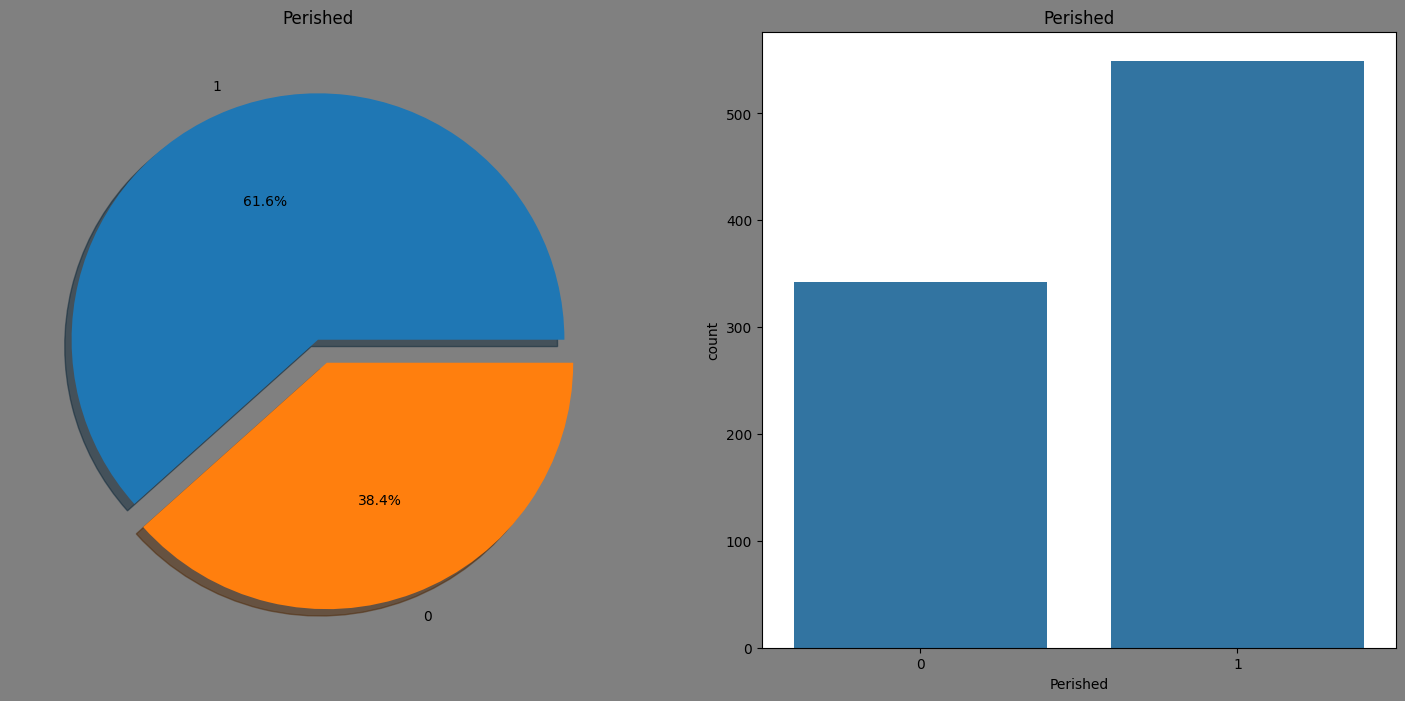

In [238]:
f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
df['Perished'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Perished')
ax[0].set_ylabel('')
sns.countplot(x='Perished',data=df,ax=ax[1])
ax[1].set_title('Perished')
plt.show()

生存率は38.4%であることがわかりました。分析対象となるデータには様々ありますが、一つの分類に**均衡データ**/**不均衡データ**というものがあります。不均衡データとは、主に予測対象のラベルの分布が著しく偏ったデータのことであり、病気の陽性/陰性などがその代表例です。不均衡データを分析する際には、データの前処理やモデルの構築、評価指標の選び方など様々な点において注意しなければなりません。しかし今回の予測対象であるPerishedは生存:死亡がおよそ4:6と均衡しているので、そうした心配の必要はありません。  

　次にデータの型について見てみましょう。機械学習を用いてデータ分析を行う際には、データの型にも注意が必要です。なぜならほとんどの機械学習モデルの実装はカテゴリカル変数を含むデータに対して学習や予測ができず、エラーとなってしまうからです。  
　データの型には大別して**数値データ**と**カテゴリカルデータ**があります。他にも日付・時間データなどがあったり、連続値データ/離散値データの区別があったりしますが、ここでは扱いません。数値データは文字通り数値が格納されたデータであり、カテゴリカルデータは主に文字列によってその分類が示されたデータです。ただしデータが数値であっても、その値の大小や順序が意味を持たない場合にはカテゴリカルデータとして扱う必要がある点には注意が必要です。  
　この観点では今回のデータは以下のように分類されます。
- 数値データ：Pclass, Age, SibSp, Parch, Fare
- カテゴリカルデータ：Name, Sex, Ticket, Embarked

　これらのカテゴリカルデータは機械学習モデルで扱えるよう、後で適切に処理します。

　ここからは一つ一つの変数について見ていきましょう。ただし、ここではデモンストレーションとして一部しか扱いません。またデータ分析コンペティションでは、必ずしも全てのEDAを自分で一から行う必要はありません。基本的なEDAは多くの場合Kaggle Notebookとして共有されますし、pandas-profilingなどの便利なライブラリを用いれば済んでしまうからです。しかし他の参加者との差別化を図るには、自らEDAで得た知見を活用する必要があります。また実務においてEDAを肩代わりしてくれる人はいません。これらの理由から、やはり自分である程度のEDAをこなせる必要はあるでしょう。

　まずは**Pclass**（チケットのクラス）について見ていきます。

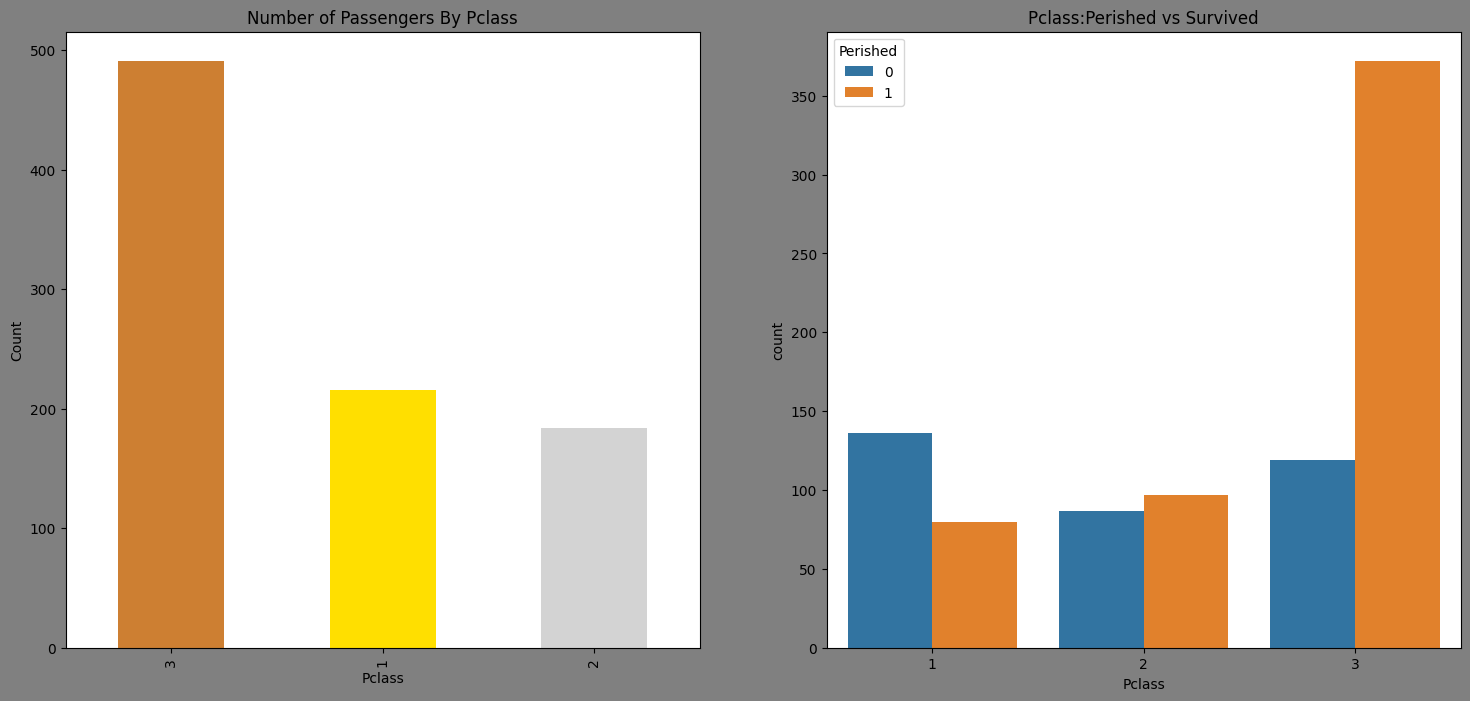

In [239]:
f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
df['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot(x='Pclass',hue='Perished',data=df,ax=ax[1])
ax[1].set_title('Pclass:Perished vs Survived')
plt.show()

　Pclassごとに人数および死亡率が著しく異なっていることが見て取れます。特にPclass=3は人数が圧倒的に多く、死亡率が著しく高いことがわかります。一方でPclass=1は死亡率が非常に低くなっています。Pclassはチケットのクラスでしたから、ここに見た事実は、Pclassの値が小さいほどチケットのグレードが高いことを直ちに示唆しています。他にはどのような知見が得られるか考えてみましょう。

　次に**Age**（年齢）について見てみます。

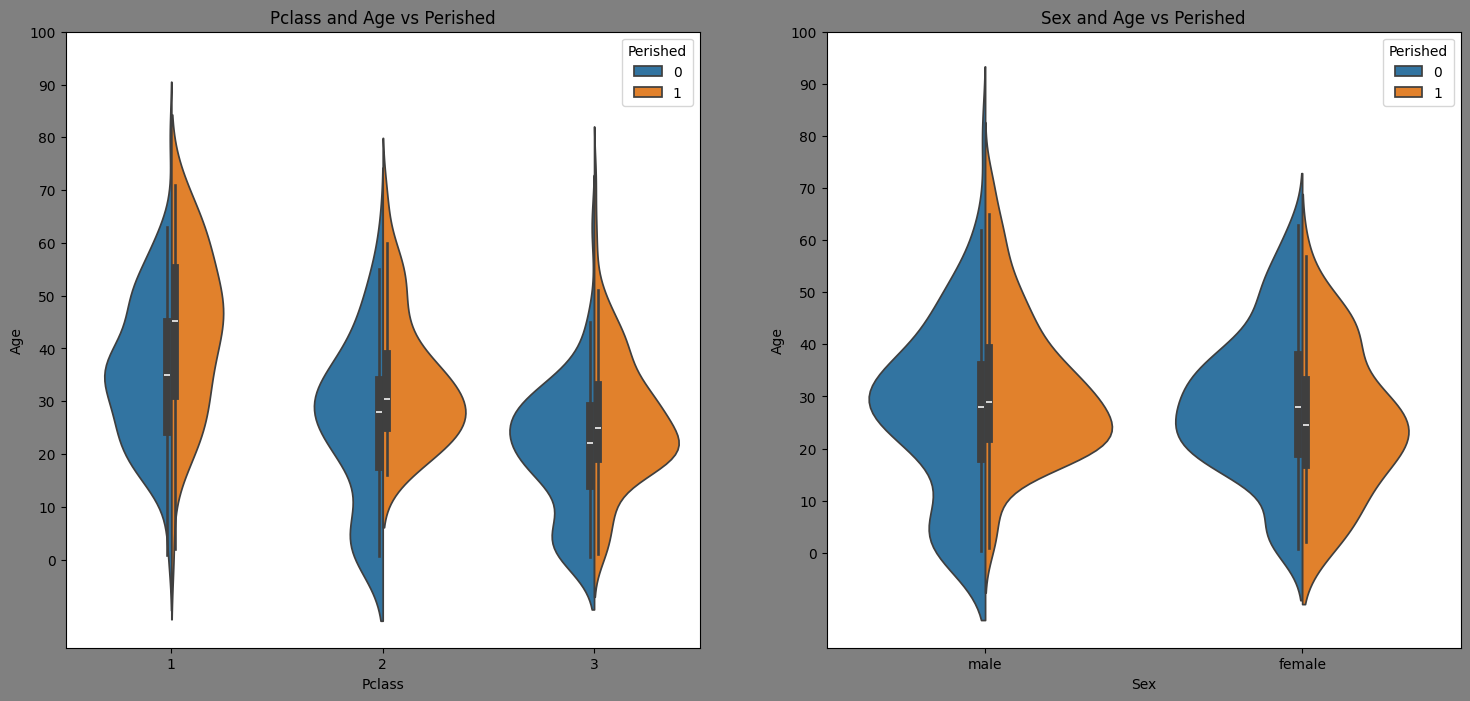

In [240]:
f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
sns.violinplot(x="Pclass",y="Age", hue="Perished", data=df,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Perished')
ax[0].set_yticks(range(0,110,10))
sns.violinplot(x="Sex",y="Age", hue="Perished", data=df,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Perished')
ax[1].set_yticks(range(0,110,10))
plt.show()

　このような図を**バイオリン図**と言います。身近なところでは人口推計の男女別年齢分布が似たような図で示されています。この図からどのような知見が得られるでしょうか。最も顕著な傾向の一つは男性の幼年層に見られます。10歳以下の男性は死亡率が著しく低くなっています。この事実はタイタニック号の事故において幼い男の子が優先的に助けられたことを示唆しています。他にはどのような知見が得られるか考えてみましょう。

　最後に**相関行列**の**ヒートマップ**を表示してみましょう。相関行列とは各成分に対応する相関係数を並べた行列のことであり、値の大小に応じて色をつけたものをヒートマップと呼びます。この図を表示することによって、変数間の相関の強さを一目で把握することができます。

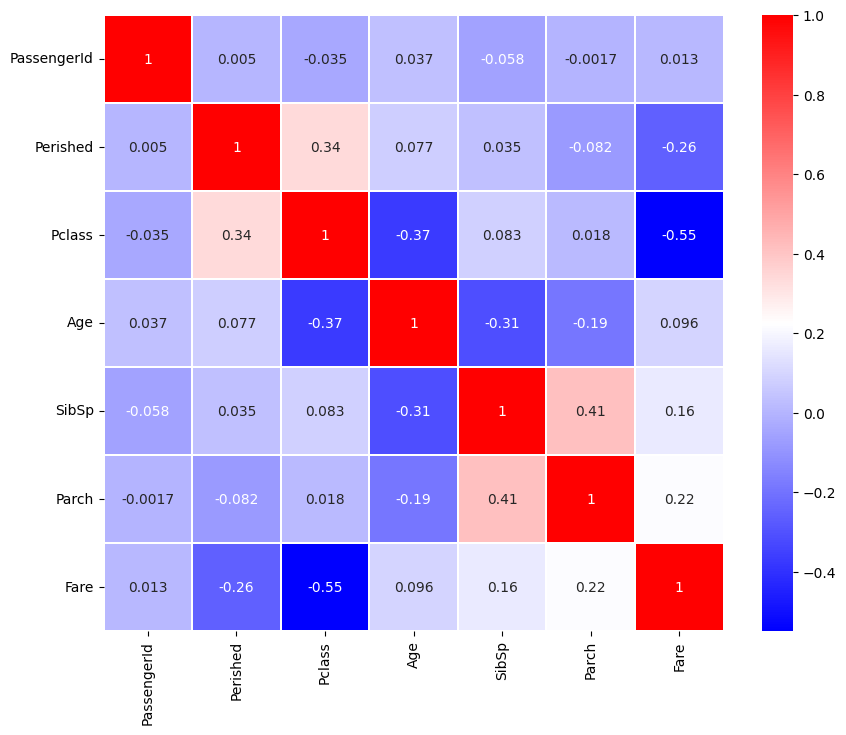

In [241]:
df_numeric = df.select_dtypes(include=['number'])
sns.heatmap(df_numeric.corr(),annot=True,cmap='bwr',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

　この図から、SibSpとParchの値に比較的強い正の相関があることがわかります。SibSpは同乗していた兄弟姉妹・配偶者の数であり、Parchは同乗していた親・子供の数であったので、この事実は理解しやすいでしょう。ここでSibSpの値とParchの値の和をとって「同乗していた家族の人数」という新しい変数を加えるアイデアが得られます。なぜならSibSpとParchという不自然な分類で二つの変数に分割してあるよりも「同乗していた家族の人数」という変数の方が自然である可能性があるからです。

　他にもPclassとFareの値に比較的強い負の相関が見られます。この事実は、先に見たようにPclassの値が小さいほどチケットのグレードが高いという見立てを補強しています。この見立ては正しいと見ていいでしょう。  

　このように相関が強い変数がある場合には注意が必要です。相関の強い変数を機械学習モデルの学習に用いると、一部のモデルでは**多重共線性**という問題が生じます。そのため著しく相関の強い変数がある場合は、その変数のうち一つだけを残して他の変数を削除するといった対策をすることがあります。ここでは相関が強すぎるという程では無いと見て、こうした対策は行いませんが、自分で試してみても良いでしょう。

## 1.3 データの前処理
　ここでは、機械学習モデルが学習できるようにデータの前処理を行なっていきます。

　まずは**欠損値**の補完です。先に見たようにAge、Fare, Cabin、Embarkedの4変数は一部が欠損していました。欠損値の補完には様々な手法があります。平均値や最頻値といった代表値で補完する手法、機械学習モデルで予測して予測値で補完する手法、-9999などの外れ値で補完することによって欠損していたという情報を保持する手法などが挙げられます。
  
　AgeとFareは数値データなので安直に平均値で補完してみましょう。この点で改善の余地は非常に大きいです。例えばNameに含まれる'Miss'と'Mrs'という敬称で平均年齢にズレがあるだろうことは容易に想像できます。余裕があればこのアイデアを実装してみたり、別のアイデアを考えてみたりしてみましょう。名案を思いついたが実装までは難しいという場合でも、他の受講生に実装のアドバイスを求めたり、そのアイデアについて議論してみたりしましょう。

#ageに関して

ageは最頻値で補完する。

In [242]:
age = pd.concat([df['Age'], df_test['Age']])
fare = pd.concat([df['Fare'], df_test['Fare']])
age_mode = age.mode()[0]
print(age_mode)
df['Age'].fillna(age_mode, inplace=True)
df_test['Age'].fillna(age_mode, inplace=True)

df['Fare'].fillna(fare.mean(), inplace=True)
df_test['Fare'].fillna(fare.mean(), inplace=True)

df.isnull().sum()
print(df_test.isnull().sum())

24.0
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


　このように、とりあえずAgeの欠損値を補完することができました。  
　次はCabinですが、欠損値の数が全体の8割近いので、削除してしまいます。削除しないでどうにか補完する方法を考えてみても良いでしょう。欠損しているかしていないかという情報も有意であることがあるので、そのような情報を保つような補完の方法でも良いかもしれません。

In [243]:
df.drop('Cabin', axis=1, inplace=True)
df_test.drop('Cabin', axis=1, inplace=True)

df.isnull().sum()

,0
PassengerId,0
Perished,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


　このようにCabinの欠損にも対処できました。  
　最後にEmbarkedの欠損値です。まずEmbarkedの分布を見てみましょう。

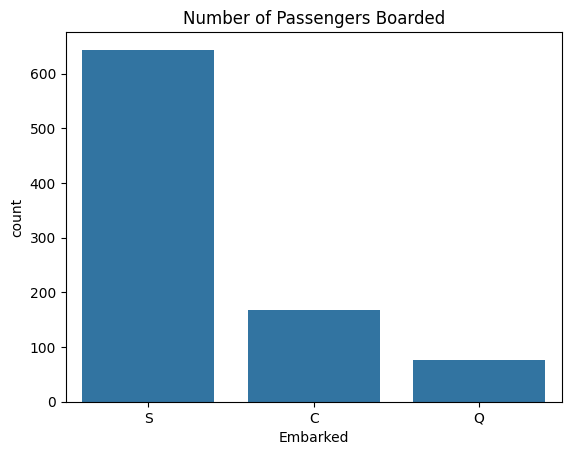

In [244]:
sns.countplot(x='Embarked',data=df)
plt.title('Number of Passengers Boarded')
plt.show()

　Embarked(乗船した港)は'S'(Southampton)が圧倒的に多いので、Embarkedの二件の欠損値は'S'で補完しておきましょう。

In [245]:
df['Embarked'].fillna('S', inplace=True)
df_test['Embarked'].fillna('S', inplace=True)

df.isnull().sum()

,0
PassengerId,0
Perished,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [246]:
df.head(20)

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,1,3,"Moran, Mr. James",male,24.0,0,0,330877,8.4583,Q
6,7,1,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
7,8,1,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S
8,9,0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S
9,10,0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C


　こうして全ての欠損値に対処することができました。

　次に**カテゴリカルデータ**を機械学習モデルで扱えるよう処理します。カテゴリカルデータには、Name, Sex, Ticket, Embarkedがありました。  
　まずはName, Ticketについてです。これらは扱いが難しいためこのデモンストレーションでは削除します。しかしこれはあまり良い判断ではありません。なぜなら前述のように'Miss'や'Mr'といった敬称が有意な情報を持っている可能性があるからです。またファミリーネームから、誰と誰が家族かという情報を得ることができる可能性もあります。Ticketに関しても同様になんらかの情報が得られる可能性は十分あります。余裕があればEDAで手がかりを探してみたり、アイデアを実装してみたりしましょう。

In [247]:
# df.drop('Name', axis=1, inplace=True)
# df_test.drop('Name', axis=1, inplace=True)

# df.drop('Ticket', axis=1, inplace=True)
# df_test.drop('Ticket', axis=1, inplace=True)

# df.columns

　次にSex（性別）です。このような二値のカテゴリカル変数は、一方を0、もう一方を1とすることで数値化することができます。ここでは男性を0、女性を1としておきます。

In [248]:
df.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
df_test.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)

df.head()

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C
2,3,0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,S
4,5,1,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,S


　最後にEmbarked（乗船した港）です。先ほど見たようにEmbarkedには'S', 'C', 'Q'の3種類の値があります。男女を0と1で置き換えたように、'S', 'C', 'Q'を0, 1, 2で置き換えれば良いでしょうか？答えは一般には"No"です。なぜなら'S'<'C'<'Q'のような大小関係は存在せず、'Q'-'C'='C'-'S'のように値の間隔が意味をもつ訳でもないからです。ではどのようにEmbarkedというカテゴリカルデータを数値化すれば良いのでしょう。その一つの手法はOne-Hot Encodingです。One-Hot Encodingとは、下図のようにしてカテゴリカルデータを0と1に変換する手法です。

![](https://blog.datascienceheroes.com/content/images/2019/07/one-hot-encoding.png)

In [249]:
embarked = pd.concat([df['Embarked'], df_test['Embarked']])

embarked_ohe = pd.get_dummies(embarked)

embarked_ohe_train = embarked_ohe[:891]
embarked_ohe_test = embarked_ohe[891:]

df = pd.concat([df, embarked_ohe_train], axis=1)
df_test = pd.concat([df_test, embarked_ohe_test], axis=1)

df.drop('Embarked', axis=1, inplace=True)
df_test.drop('Embarked', axis=1, inplace=True)

df.head()

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,C,Q,S
0,1,1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,False,False,True
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,True,False,False
2,3,0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,False,False,True
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,False,False,True
4,5,1,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,False,False,True


In [250]:
df["Mr"] = False
df_test["Mr"] = False
for i in range(len(df)):
    if df.iloc[i]["Name"].find("Mr.") != -1:
        df["Mr"][i] = True
for i in range(len(df_test)):
    if df_test.iloc[i]["Name"].find("Mr.") != -1:
        df_test["Mr"][i] = True

sum(df["Mr"])/len(df)

df.drop('Name', axis=1, inplace=True)
df_test.drop('Name', axis=1, inplace=True)


In [251]:
df['Family'] = df['SibSp'] + df['Parch']
df_test['Family'] = df_test['SibSp'] + df_test['Parch']

df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
df_test.drop(['SibSp', 'Parch'], axis=1, inplace=True)
df.head(10)

,PassengerId,Perished,Pclass,Sex,Age,Ticket,Fare,C,Q,S,Mr,Family
0,1,1,3,0,22.0,A/5 21171,7.2500,False,False,True,True,1
1,2,0,1,1,38.0,PC 17599,71.2833,True,False,False,False,1
2,3,0,3,1,26.0,STON/O2. 3101282,7.9250,False,False,True,False,0
3,4,0,1,1,35.0,113803,53.1000,False,False,True,False,1
4,5,1,3,0,35.0,373450,8.0500,False,False,True,True,0
5,6,1,3,0,24.0,330877,8.4583,False,True,False,True,0
6,7,1,1,0,54.0,17463,51.8625,False,False,True,True,0
7,8,1,3,0,2.0,349909,21.0750,False,False,True,False,4
8,9,0,3,1,27.0,347742,11.1333,False,False,True,False,2
9,10,0,2,1,14.0,237736,30.0708,True,False,False,False,1


In [252]:
# df["alone"] = [1]*len(df)
# df_test["alone"] = [1]*len(df_test)
# for i in range(len(df)):
#     if df.iloc[i]["Family"] == 0:
#         df["alone"][i] = 0
# for i in range(len(df_test)):
#     if df_test.iloc[i]["Family"] == 0:
#         df_test["alone"][i] = 0

In [253]:
df.describe(include = 'all')
df.drop('Ticket', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)
df.head()

,PassengerId,Perished,Pclass,Sex,Age,Fare,C,Q,S,Mr,Family
0,1,1,3,0,22.0,7.2500,False,False,True,True,1
1,2,0,1,1,38.0,71.2833,True,False,False,False,1
2,3,0,3,1,26.0,7.9250,False,False,True,False,0
3,4,0,1,1,35.0,53.1000,False,False,True,False,1
4,5,1,3,0,35.0,8.0500,False,False,True,True,0


In [254]:
df

,PassengerId,Perished,Pclass,Sex,Age,Fare,C,Q,S,Mr,Family
0,1,1,3,0,22.0,7.2500,False,False,True,True,1
1,2,0,1,1,38.0,71.2833,True,False,False,False,1
2,3,0,3,1,26.0,7.9250,False,False,True,False,0
3,4,0,1,1,35.0,53.1000,False,False,True,False,1
4,5,1,3,0,35.0,8.0500,False,False,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...
886,887,1,2,0,27.0,13.0000,False,False,True,False,0
887,888,0,1,1,19.0,30.0000,False,False,True,False,0
888,889,1,3,1,24.0,23.4500,False,False,True,False,3
889,890,0,1,0,26.0,30.0000,True,False,False,True,0


　このようにして、全てのカテゴリカルデータを処理することができました。

## 2. ベースラインモデルの構築

　ここでようやくモデルの構築に入ります。モデルの構築においては、まずベースラインとなるモデルを作成することが多いです。ベースラインモデルは、機械学習モデルが学習できる形にデータが整形されているか確認することや、改良されたモデルと比較して改良の効果を評価することが主な目的です。ベースラインモデルは、あまり学習に時間のかからないモデルを用います。ここでは、ベースラインモデルとしてよく用いられるランダムフォレストを使用します。ランダムフォレストのアルゴリズムについては講義で学びますが、簡単に説明すると複数の決定木の多数決によって予測を行う機械学習モデルになります。  
　まずdfとdf_testを**説明変数**と**目的変数**に分けます。
- 説明変数：モデルの学習に使用する変数、今回の問題ではPassengerId, Perished以外の変数
- 目的変数：予測対象の変数, 今回の問題ではPerished

　ここでスライスしたdfとdf_testを.valuesとしてnumpy.ndarray型に変換しているのは、機械学習モデルの実装によってはこの型のデータしか受け付けないからです。

In [255]:
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

X_test = df_test.iloc[:, 1:].values

In [256]:
len(X)

891

　機械学習モデルにとって最大の障害の一つは**過学習**です。過学習とは機械学習モデルが訓練データを学習する際に、訓練データに対して正しい予測を与えようとするあまり、訓練データにしか良い予測を与えられず、テストデータや他のデータに対して役に立たなくなってしまう現象のことです。

　この現象を回避するための手法の一つに**ホールドアウト法**があります。ホールドアウト法では、与えられた訓練データをさらに擬似訓練データと擬似テストデータに分割し、機械学習モデルを擬似訓練データで学習させます。その上で、擬似訓練データに対する予測精度と擬似テストデータに対する予測精度を比較して、二つの値に大きな解離が見られる場合には過学習が発生していると判断し、過学習を抑えるよう修正を加えます。  

　今回は7:3で元の訓練データを分割して、擬似訓練データ(X_train, y_train)と擬似テストデータ(X_valid, y_valid)とします。変数名は何でも構いませんが、ここで用いたvalidとはvalidation(検証)の略です。これは擬似テストデータをモデルの予測精度の検証に用いることに由来します。

　データの分割には、scikit-learnのtrain_test_split関数を使用しますが、分割はランダムに行われるため、再現性を保つためには乱数生成のシード値を引数random_stateで指定する必要があります。この値を42とする例が海外を中心に散見されるのは、この数字が、有名なSF作品「銀河ヒッチハイク・ガイド」で「生命、宇宙、そして万物についての究極の疑問の答え」とされているからだそうです。

　ホールドアウト法の拡張には、**クロスバリデーション**があります。クロスバリデーションについては後で改めて解説します。

In [257]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

　ランダムフォレストモデルを作成して、擬似訓練データ(X_train, y_train)を学習させます。ランダムフォレストモデルを作成する際に指定できる主な引数は以下の通りです。不明な用語がいくつかあるかもしれませんが、いずれ講義で解説があります。またこれら以外にも様々な引数があるので、公式ドキュメントなどを参照してみてください。
- max_depth：決定木の深さの最大値
- min_samples_leaf：葉が含むサンプル数の最小値
- n_estimators：決定木の数
- n_jobs：計算に用いるスレッド数
- random_state：乱数生成のシード値

In [258]:
rfc = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

　このモデルによる予測精度の評価を、今回のコンペティションで指定された評価基準である**正解率(accuracy)**で行います。先述したように、擬似訓練データ(X_train, y_train)に対するスコアと擬似テストデータ(X_valid, y_valid)に対するスコアを見ます。これらの値が著しく解離している場合には、**過学習**が発生しているとして修正を行います。

In [259]:
print('Train Score: {}'.format(round(rfc.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(rfc.score(X_valid, y_valid), 3)))

Train Score: 0.95
 Test Score: 0.806


　擬似訓練データに対する正解率が約95%であるのに対して、擬似テストデータに対する正解率が約79%となっています。これは明らかに**過学習**が発生している状況となっています。テストデータに対して良い予測を得るためにはこの状況を改善することが不可欠です。  
　過学習を解決するためには機械学習の**ハイパーパラメータ**を調整する必要があります。ハイパーパラメータとは、機械学習モデルを作成する際に予め指定する必要のあるパラメータであり、データを学習しても更新されません。ランダムフォレストモデルの場合はmax_depth(決定木の深さの最大値)やmin_samples_leaf(葉が含むサンプル数の最小値)などがそれにあたります。例えば、max_depthの値を大きく設定するほど過学習の傾向が強まりますが、逆にmax_depthの値が小さすぎるとそもそもモデルの精度が得られません（この状況を過学習に対して**未学習**と呼びます）。  
　過学習に起因する誤差を**バリアンス**、未学習に起因する誤差を**バイアス**と呼びますが、バリアンスとバイアスはトレードオフの関係にあります。そのため良いモデルを作成するためには、バリアンスとバイアスの両方を抑えられるようなハイパーパラメータを見つける必要があります。このようなハイパーパラメータを見つける方法には、**グリッドサーチ**と呼ばれるものや、**ベイズ最適化**を用いるものなどがあります。ここではグリッドサーチを紹介します。  
　グリッドサーチとは、複数のハイパーパラメータを同時に最適化するため，離散的に指定されたハイパーパラメータの組に基づいて，しらみつぶしにモデルの予測精度を評価する手法です。ここではmax_depthの候補として(3, 5, 7)、min_samples_leafの候補として(1, 2, 4)を取ってみましょう。

In [260]:
param_grid = {'max_depth': [3, 5, 7],
              'min_samples_leaf': [1, 2, 4]}

for max_depth in param_grid['max_depth']:
    for min_samples_leaf in param_grid['min_samples_leaf']:
        rfc_grid = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                            n_estimators=100, n_jobs=-1, random_state=42)
        rfc_grid.fit(X_train, y_train)
        print('max_depth: {}, min_samples_leaf: {}'.format(max_depth, min_samples_leaf))
        print('    Train Score: {}, Test Score: {}'.format(round(rfc_grid.score(X_train, y_train), 3),
                                                           round(rfc_grid.score(X_valid, y_valid), 3)))

max_depth: 3, min_samples_leaf: 1
    Train Score: 0.839, Test Score: 0.825
max_depth: 3, min_samples_leaf: 2
    Train Score: 0.838, Test Score: 0.825
max_depth: 3, min_samples_leaf: 4
    Train Score: 0.836, Test Score: 0.825
max_depth: 5, min_samples_leaf: 1
    Train Score: 0.875, Test Score: 0.821
max_depth: 5, min_samples_leaf: 2
    Train Score: 0.875, Test Score: 0.81
max_depth: 5, min_samples_leaf: 4
    Train Score: 0.867, Test Score: 0.81
max_depth: 7, min_samples_leaf: 1
    Train Score: 0.909, Test Score: 0.806
max_depth: 7, min_samples_leaf: 2
    Train Score: 0.889, Test Score: 0.802
max_depth: 7, min_samples_leaf: 4
    Train Score: 0.876, Test Score: 0.799


　このグリッドサーチは、先に軽く触れた**クロスバリデーション**と組み合わせて行われることが多いです。クロスバリデーションはホールドアウト法の拡張となっています。ホールドアウト法では訓練データを擬似訓練データと擬似テストデータの二つに分けましたが、クロスバリデーションでは自然数Nを指定してデータをN個に分割します。こうして分割されたN個のデータのうち1つを擬似テストデータ、残りを擬似訓練データとして学習と評価を行います。N個のデータがそれぞれ一回ずつ擬似テストデータとなるようN回の学習と評価を行い、得られたスコアの平均をそのモデルのスコアとします。下図を参照してください。  
　このようにすることで、モデルの擬似テストデータに対するスコアがデータの分割方法に依らなくなることが期待されます。ホールドアウト法では、データを2つに分けてしまうため、データの分割方法によっては擬似訓練データと擬似テストデータに偏りが生じてしまいますが、クロスバリデーションではそのような可能性が平均操作により軽減されます。

![](http://musashi.osdn.jp/tutorial/mining/xtclassify/nfold.jpg)

　今回は訓練データを5分割してクロスバリデーションしてみましょう。

In [261]:
rfc_gs = GridSearchCV(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), param_grid, cv=5)
rfc_gs.fit(X, y)

print('Best Parameters: {}'.format(rfc_gs.best_params_))
print('CV Score: {}'.format(round(rfc_gs.best_score_, 3)))

Best Parameters: {'max_depth': 7, 'min_samples_leaf': 4}
CV Score: 0.831


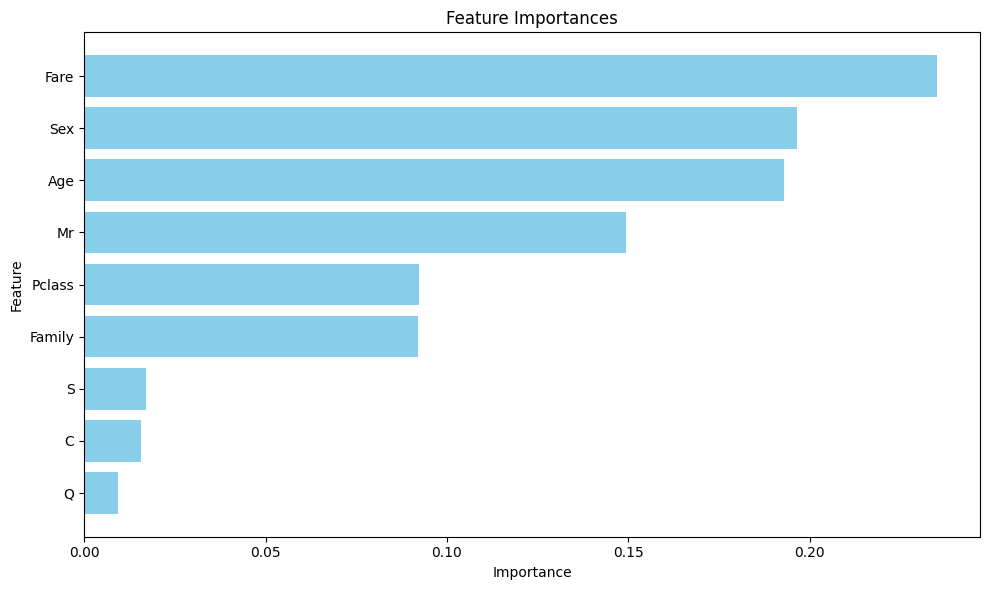

In [262]:
# 特徴量の重要度を取得
importances = rfc.feature_importances_
feature_names = df.iloc[:, 2:].columns

# データフレームにまとめる
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 重要度でソート
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # 重要度の高い順に表示
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

　ここではとりあえず、max_depth=7, min_samples_leaf=1と設定したランダムフォレストが得られました。データ分析コンペティションに取り組む際には、より詳細にハイパーパラメータをチューニングすべきです。しかしまだベースラインモデルの構築段階なので、まだここでは本格的にパラメータチューニングする必要は無いでしょう。

## 3. 特徴量エンジニアリング
　次に**特徴量エンジニアリング**に取り組みます。特徴量エンジニアリングとは、説明変数に手を加えることでモデルの学習に効果的な変数（**特徴量**）を作成しようという試みです．特徴量エンジニアリングには、大きく分けて二つの方向性があります。一つは問題設定に依らない汎用的な手法を用いるものです。カテゴリカルデータの**エンコーディング**や**交差項**の作成などがこれにあたります。例えば、カテゴリ値のエンコーディングには先に紹介した**One-Hot Encoding**の他にも、**Label Encoding**、**Count Encoding**、**LabelCount Encoding**、**Target Encoding**、**Likelyhood Encoding**など様々あります。カテゴリ値のエンコーディングに関してはHJ van Veen氏の"Feature Engineering"が参考になります。

"Feature Engineering": https://www.slideshare.net/HJvanVeen/feature-engineering-72376750  

　また交差項とは、複数の説明変数の積です。交差項を特徴量として追加することによって、モデルの表現力が向上する場合があります。ただ交差項といっても何次の交差項まで考えるのか、何変数の交差項まで考えるのかなど、検証すべき点は多く存在します。また積だけでなく、四則演算や一般の演算に拡張することもできます。

　もう一つの方針は，**ドメイン知識**に基づく特徴量エンジニアリングです．ドメイン知識とは，それぞれ問題に特有な背景知識のことです．今回の問題の場合は「海難事故だから、こうした特徴量が鍵を握っているだろう」といった背景的な知識に基づいて特徴量を作り込んで行くことになります。

　データ分析コンペティションで最も大きく差の付く要因の一つがこの特徴量エンジニアリングです。ここでは、EDAから得られたアイデアである「SibSpの値とParchの値の和をとって、Family(同乗していた家族の人数)という新しい変数を加える」を試してみましょう。

In [263]:
# df_fe = df.copy()
# df_fe_test = df_test.copy()

# df_fe['Family'] = df['SibSp'] + df['Parch']
# df_fe_test['Family'] = df_test['SibSp'] + df_test['Parch']

# df_fe.drop(['SibSp', 'Parch'], axis=1, inplace=True)
# df_fe_test.drop(['SibSp', 'Parch'], axis=1, inplace=True)
# df_fe.head(10)

　このようにして得られた新たなデータを、先ほどのベースラインモデルと同様の構成のランダムフォレストに学習させてみます。

　このアイデアは上手くいかず精度が下がってしまいまったので、採用しないこととします。特徴量エンジニアリングでは、このような試行錯誤を繰り返しながら特徴量を作り込んでいきます。余裕があれば、自分のアイデアを実装してみて、効果的な特徴量を見つけてみましょう。

## 4. 様々なモデルの構築・調整
　ベースラインモデルにはランダムフォレストを採用しましたが、機械学習モデルには他にも様々存在します。機械学習を用いたデータ分析では、用いる機械学習モデルを多様化することが重要です。なぜならそれぞれの機械学習モデルには前提としているデータの特徴があるなどして、得意不得意があったり予測に偏りがあったりするからです。こうした機械学習モデルごとの傾向は、複数のモデルを用意して**アンサンブリング**することによってキャンセルすることができます。アンサンブリングについては後で説明します。それぞれの機械学習モデルの特徴については、HJ van Veen氏の"Winning Kaggle Competition"にまとめられています。

"Winning Kaggle Competition": https://www.slideshare.net/HJvanVeen/kaggle-presentation

　今回はランダムフォレストの他に、ロジスティック回帰・多層パーセプトロンを作成してみます。ここではグリッドサーチやクロスバリデーションを用いたハイパーパラメータのチューニングは行いませんが、自分でデータ分析コンペティションに取り組む際にはちゃんと行うべきでしょう。  

　まずはロジスティック回帰モデルです。

In [264]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

print('Logistic Regression \n')
print('Train Score: {}'.format(round(lr.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(lr.score(X_valid, y_valid), 3)))

Logistic Regression 

Train Score: 0.819
 Test Score: 0.799


　次に多層パーセプトロンモデルです。

In [265]:
mlpc = MLPClassifier(hidden_layer_sizes=(100, 100, 10), random_state=0)
mlpc.fit(X_train, y_train)

print('Multilayer Perceptron \n')
print('Train Score: {}'.format(round(mlpc.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(mlpc.score(X_valid, y_valid), 3)))

Multilayer Perceptron 

Train Score: 0.828
 Test Score: 0.791


#  K近傍法でも試してみる

参考にしたサイトは最後に記載してある

In [266]:
n_neighbors = 3
# モデルの学習
knc = KNeighborsClassifier(n_neighbors=n_neighbors)
knc.fit(X_train, y_train)

print('KNeighborsClassifier \n')
print('Train Score: {}'.format(round(knc.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(knc.score(X_valid, y_valid), 3)))
# テストデータの分類予測
# y_pred = knc.predict(x)

KNeighborsClassifier 

Train Score: 0.839
 Test Score: 0.716


#  GradientBoostingClassifierも試してみる

In [267]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

print('GradientBoostingClassifier \n')
print('Train Score: {}'.format(round(gbc.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(gbc.score(X_valid, y_valid), 3)))

GradientBoostingClassifier 

Train Score: 0.909
 Test Score: 0.817


In [268]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
print('XGBClassifier \n')
print('Train Score: {}'.format(round(xgb.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(xgb.score(X_valid, y_valid), 3)))

XGBClassifier 

Train Score: 0.971
 Test Score: 0.799


　これで、ランダムフォレスト・ロジスティック回帰・多層パーセプトロンという三つのモデルが得られました。

## 5. モデルのアンサンブリング
　先に述べたように、複数のモデルを**アンサンブリング**することによってより頑健なモデルとすることができます。アンサンブリングとは、複数のモデルを組み合わせて一つのモデルとすることです。アンサンブリングには、**バギング**・**ブースティング**・**スタッキング**など様々な手法がありますが、最もシンプルな手法は複数のモデルの予測値の重み付け平均を最終的な予測値とすることです。分類問題では、これは複数のモデルによる重み付け多数決となっています。  
　今回は、単純に3つのモデルの予測値の算術平均を四捨五入して最終的な予測としましょう。ただしこれら3つのモデルは、予測値を確率として表すことができるので、この確率的な予測値の平均を用います。  
　このような四捨五入の場合0.5が閾値となってPerishedの値を決定しますが、必ずしもその閾値は0.5が良いとは限りません。問題や評価指標によっては、より小さい値を閾値にした方が良い場合もありますし、より大きい値を閾値とした方が良い場合もあります。つまりこの点についても改良の余地は存在します。

#  多層パーセプトロンとK近傍法は評価があまりよくないので含めない


In [279]:
rfc_pred = rfc_gs.predict_proba(X_test)
lr_pred = lr.predict_proba(X_test)
mlpc_pred = mlpc.predict_proba(X_test)
knc_pred = knc.predict_proba(X_test)
gbc_pred = gbc.predict_proba(X_test)

pred_proba = (rfc_pred+gbc_pred+lr_pred)/3

pred_int_1 = pred_proba.argmax(axis=1)

　このようにして提出すべき予測値が得られました。

In [287]:
def show_bar(pred_proba):
    # ヒストグラムを描画し、counts と bins を取得
    counts, bins, patches = plt.hist(pred_proba[:, 1], bins=20, edgecolor='black')

    # 各ビンの中央を計算
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # 各ビンの上に数値を表示
    for count, x in zip(counts, bin_centers):
        plt.text(x, count, f'{int(count)}', ha='center', va='bottom', fontsize=9)
    plt.show()

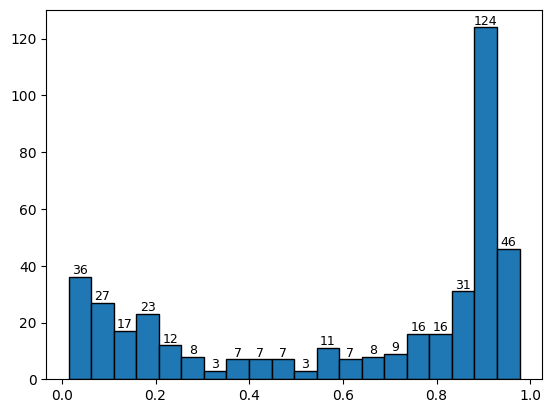

In [281]:
show_bar(pred_proba)

In [282]:
X_all = np.vstack((X, X_test))
y_all = np.hstack((y, pred_int_1))
print(X.shape, y.shape)

(891, 9) (891,)


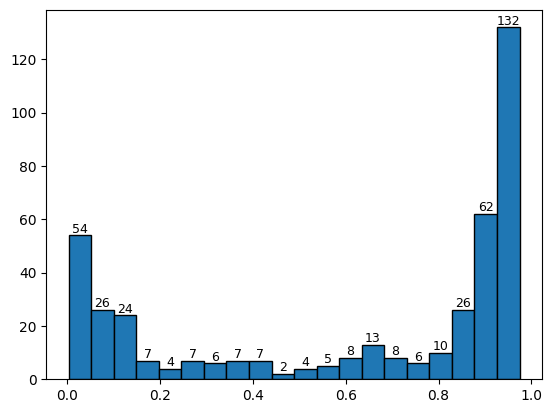

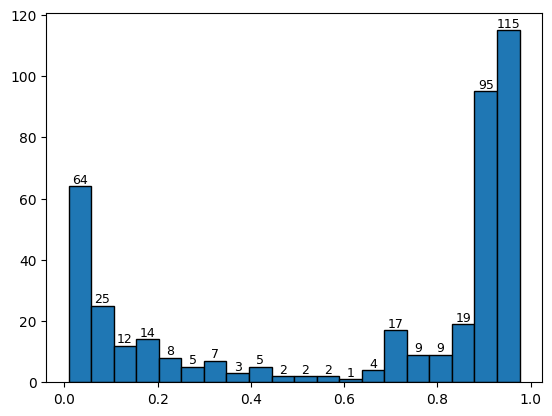

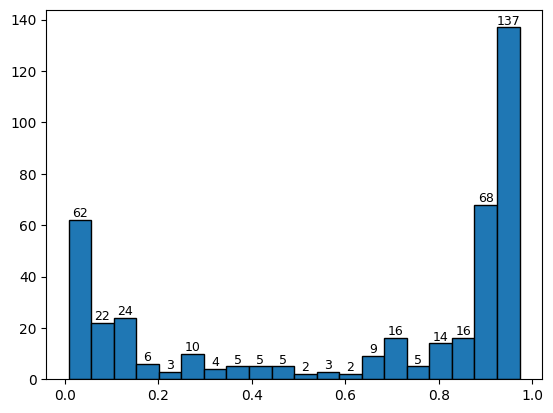

In [288]:
rfc_gs.fit(X_all, y_all)
gbc.fit(X_all, y_all)
rfc_pred = rfc_gs.predict_proba(X_test)
show_bar(rfc_pred)
gbc_pred = gbc.predict_proba(X_test)
show_bar(gbc_pred)
pred_proba = (rfc_pred+gbc_pred)/2
pred = pred_proba.argmax(axis=1)
show_bar(pred_proba)

## 6. 予測の出力・提出
　最後に得られた予測値を規定の形式に整形して、csvファイルとして出力しましょう。  
　まず規定の形式を確認しましょう。README.ipynbでは以下のようなcsvファイルで提出するよう指示されていました。

PassengerID|Perished
---|---
892|1
893|0
894|1
…|…
1307|1
1308|1
1309|1

　また、gender_submission.csvがその例とされていたので、これを確認します。\
※ファイルの読み込み方法は自身の作業場所によって変わります。このnotebookをコピーして用いる場合はそのまま実行することができますが、自分の環境に合わせて適切な形に修正する必要が生じる場合もあります。

In [274]:
 # 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
# path = "/content/drive/My Drive/松尾研/GCI/コンペ１/"
submission = pd.read_csv(path + 'gender_submission.csv')
submission

,PassengerId,Perished
0,892,1
1,893,0
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


　提出ファイルを作成するには、このデータフレームのPerishedを上書きするのが手っ取り早いでしょう。

In [275]:
pred.shape

(418,)

In [276]:
if path ==  "/content/drive/My Drive/松尾研/GCI/コンペ１/":
    submission["Perished"] = pred
else:
    submission["Survived"] = pred

print(submission)
#  もしkaggleに提出する場合は以下のコードを実行す
# submission.rename(columns={'Perished': 'Survived'}, inplace=True)
submission

     PassengerId  Perished
0            892         1
1            893         1
2            894         1
3            895         1
4            896         0
..           ...       ...
413         1305         1
414         1306         0
415         1307         1
416         1308         1
417         1309         0

[418 rows x 2 columns]


,PassengerId,Perished
0,892,1
1,893,1
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


　これをcsvファイルとして出力すれば、提出ファイルの完成です。\
※csvファイル書き出しの方法は自身の作業場所によって変わります。自分の環境に合わせたコード片方を選択してください。両方または自分の環境外のコードを選択するとエラーが起こります。このnotebookをコピーして用いる場合は下のセルをそのまま実行してください。

In [277]:
# JupyterLabなどローカルで作業する場合
# パスは必要に応じて変更の必要あ
# submission.to_csv('/content/drive/My Drive/Colab Notebooks/GCI_2024_winter/Competitions/competition_1/submission.csv', index=False)

In [278]:
# Google Drive・Google Colaboratoryで作業する場

if submission.columns[1] == 'Survived':
    submission.to_csv('submission_to_kaggle_titanic.csv', index=False)
    path = "/content/drive/My Drive/松尾研/GCI/コンペ１/"
    correct = pd.read_csv(path + 'correct.csv')
    ans = 0
    for i in range(len(correct)):
      if correct['Survived'][i] == submission['Survived'][i]:
            ans += 1
    print(f"あなたの正解率は{ans/len(correct)}です")
else:
    faile_name = "16.csv"
    submission.to_csv(faile_name,index=False)
    print(submission)
    print(f"{faile_name}をOmnicampusに提出してください")

# from google.colab import files
# files.download('submission.csv')

     PassengerId  Perished
0            892         1
1            893         1
2            894         1
3            895         1
4            896         0
..           ...       ...
413         1305         1
414         1306         0
415         1307         1
416         1308         1
417         1309         0

[418 rows x 2 columns]
16.csvをOmnicampusに提出してください


　この提出ファイルをOmnicampus上で提出してみましょう。本デモンストレーションはこれにて以上です。入門者の方もこのデモンストレーションをベースとするなどし、自分の工夫を一つでも多く加えてみて、スコアと順位の向上を目指してみてください。

#  以下参考にしたサイト一覧

kncの実装：https://qiita.com/kwi0303/items/98d5455db06e82bc7a6d
